In [22]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prometheus_api_client.utils import parse_datetime
from prometheus_api_client import PrometheusConnect

In [29]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("airbyte")]

# Sort list
airflow_files = sorted(airflow_files)
airbyte_files = sorted(airbyte_files)

print(airflow_files, airbyte_files, sep='\n')

['airflow_populate_source.txt', 'airflow_populate_target.txt', 'airflow_status.txt']
['airbyte_populate_source.txt', 'airbyte_populate_target.txt', 'airbyte_status.txt']


In [30]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airflow + Spark"
            lst.append(temp_json)
            
for file, lst in zip(airbyte_files, [source, target]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airbyte"
            lst.append(temp_json)        
            
            
status_airbyte = []
with open(path + airbyte_files[-1]) as f:
    for line in f:
        temp_json = json.loads(line)
        temp_json['framework'] = "Airbyte"
        status_airbyte.append(temp_json)                     

In [31]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')
status_airbyte = pd.DataFrame.from_dict(status_airbyte, orient='columns')

display(source.head(3))
display(target.head(3))
display(status.head(3))
display(status_airbyte.head(3))

,benchmark_id,operation,start_time,end_time,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,cashtransaction,361856,41091072,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,dailymarket,1282768,98697216,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,date,25933,7340032,Airflow + Spark


,benchmark_id,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,3,cashtransaction,361856,40615936,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,3,dailymarket,1282768,98213888,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,3,date,25933,6856704,Airflow + Spark


,benchmark_id,startTime,endTime,TimeDelta,operation,framework
0,MjAyMzExMDgxMjM3NDQ=,2023-11-08T12:38:07.590649+00:00,2023-11-08T12:39:14.198780+00:00,66.61,sync_airflow,Airflow + Spark
1,MjAyMzExMDgxMjM5MTU=,2023-11-08T12:39:41.551226+00:00,2023-11-08T12:41:04.374189+00:00,82.82,sync_airflow,Airflow + Spark
2,MjAyMzExMDgxMjQxMDk=,2023-11-08T12:41:40.638150+00:00,2023-11-08T12:43:19.428467+00:00,98.79,sync_airflow,Airflow + Spark


,jobId,jobType,startTime,bytesSynced,rowsSynced,TimeDelta,Throughput,operation,benchmark_id,framework
0,123,sync,2023-11-07 13:58:54,6.107011e+08,4525390.0,192,23569.74,sync_airbyte,MjAyMzExMDcxMzU4MjA=,Airbyte
1,125,sync,2023-11-07 14:02:49,8.317040e+08,6160471.0,252,24446.31,sync_airbyte,MjAyMzExMDcxNDAyMDk=,Airbyte
2,127,sync,2023-11-07 14:07:47,1.043358e+09,7779939.0,327,23791.86,sync_airbyte,MjAyMzExMDcxNDA3MDU=,Airbyte


In [32]:
# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Source fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
# status_airbyte fix types
status_airbyte.startTime = pd.to_datetime(status_airbyte.startTime, format="%Y-%m-%d %H:%M:%S")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()


In [33]:
source_grouped = source.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
target_status = target[["framework", "benchmark_id", "sf"]].merge(status, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status = target_status.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()
# join source and status aibyte
target_status_airbyte = target[["framework", "benchmark_id", "sf"]].merge(status_airbyte, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status_airbyte = target_status_airbyte.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_status_combined = pd.concat([target_status, target_status_airbyte])

# Calculate Aiflow + Spark Throughput
temp_join = target_status.merge(target_grouped, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")
temp_join["Throughput"] = temp_join.rows_count / temp_join.TimeDelta
temp_join = temp_join[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]

# target_grouped
df_throughput = status_airbyte[['benchmark_id', 'TimeDelta', 'framework']].merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
df_throughput['Throughput'] = df_throughput.rows_count / df_throughput.TimeDelta
df_throughput = pd.concat([temp_join, df_throughput])

display(source_grouped.head(3))
display(target_status.head(3))

,framework,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,Airbyte,MjAyMzExMDcxMzU4MjA=,3,4525390,413368320,17.896000
1,Airbyte,MjAyMzExMDcxNDA3MDU=,5,7779939,704872448,25.865250
2,Airbyte,MjAyMzExMDcxNDAyMDk=,4,6160471,562806784,23.860181


,framework,benchmark_id,sf,TimeDelta
0,Airflow + Spark,MjAyMzExMDgxMjM3NDQ=,3,66.61
1,Airflow + Spark,MjAyMzExMDgxMjM5MTU=,4,82.82
2,Airflow + Spark,MjAyMzExMDgxMjQ1NTk=,7,130.50


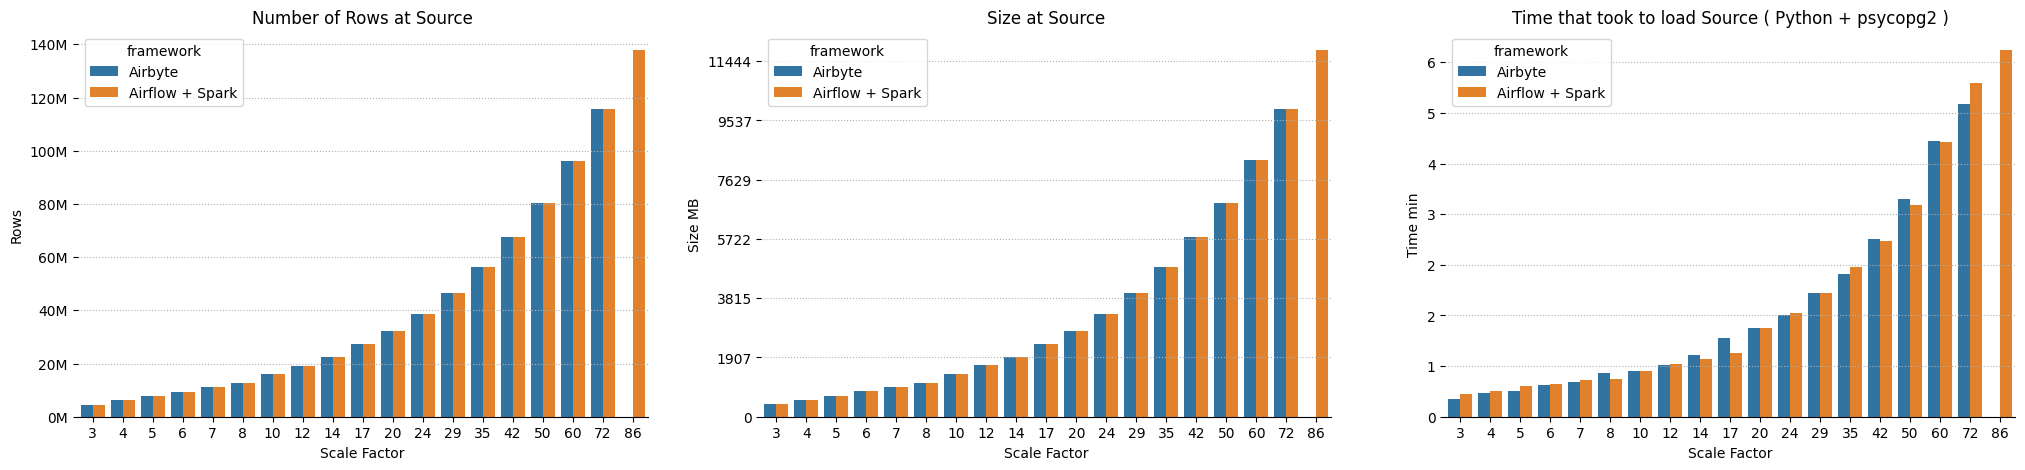

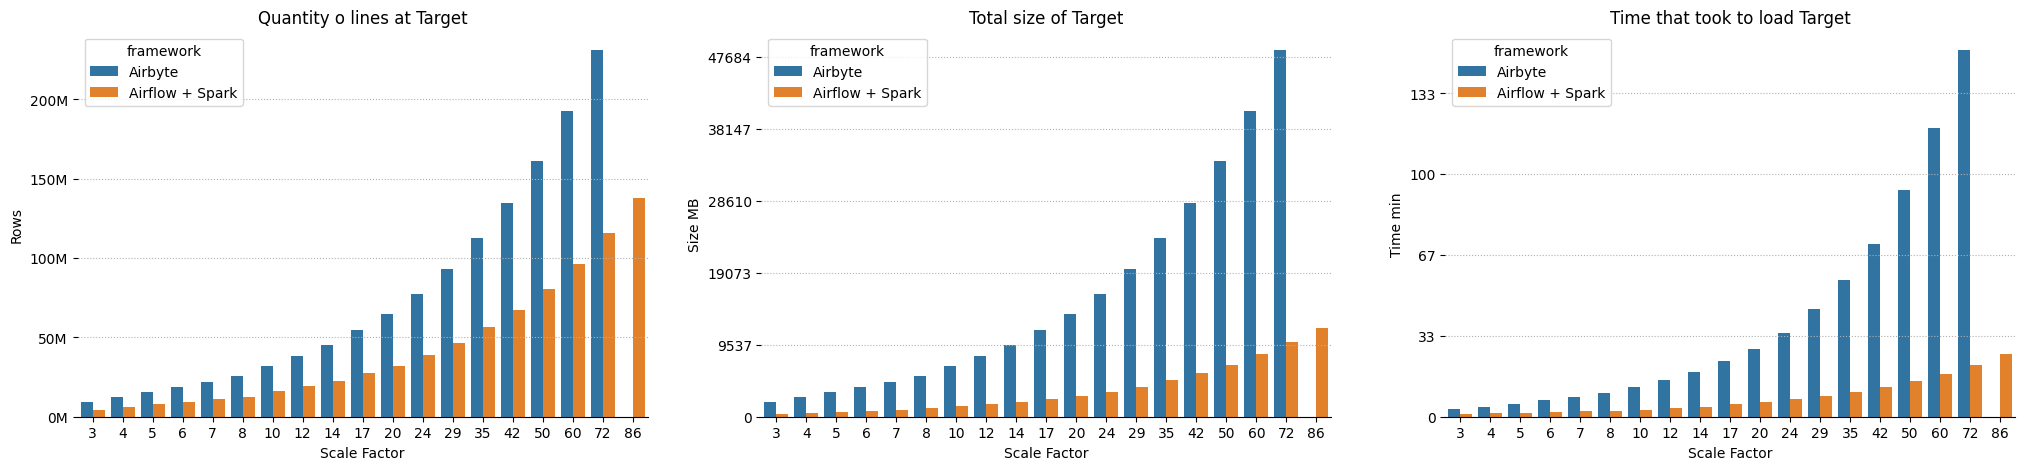

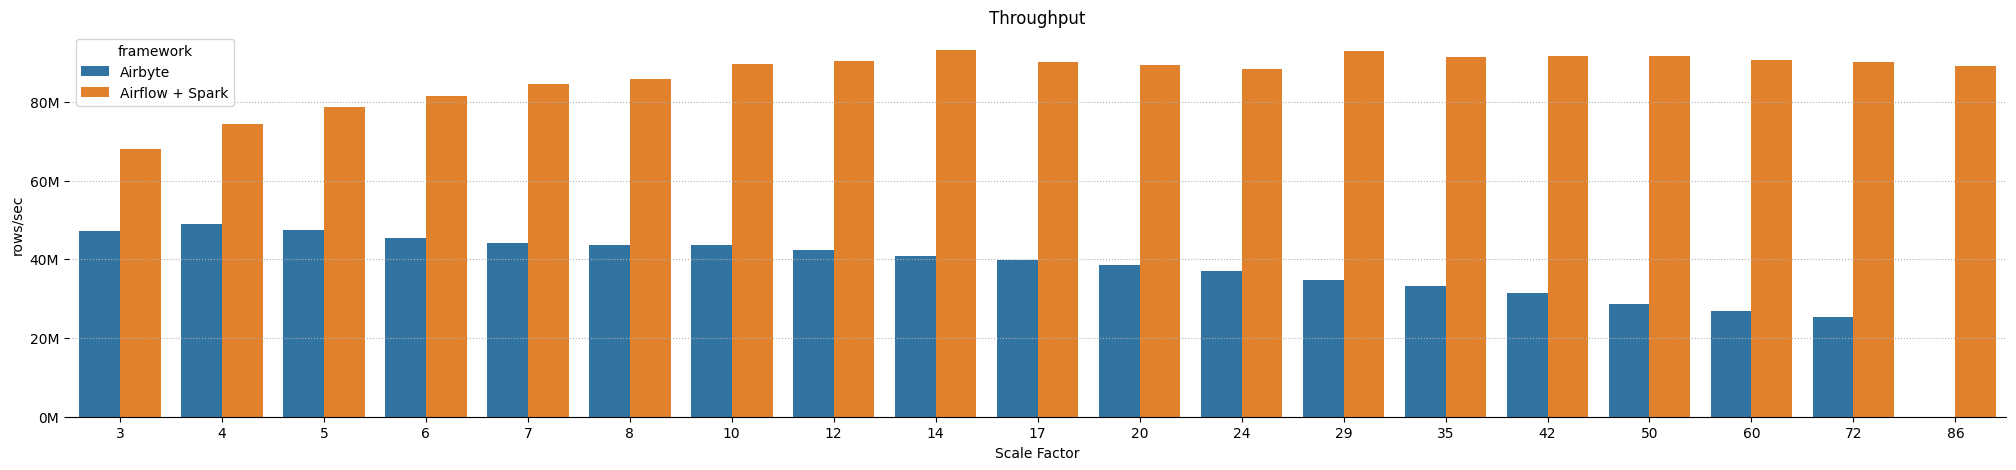

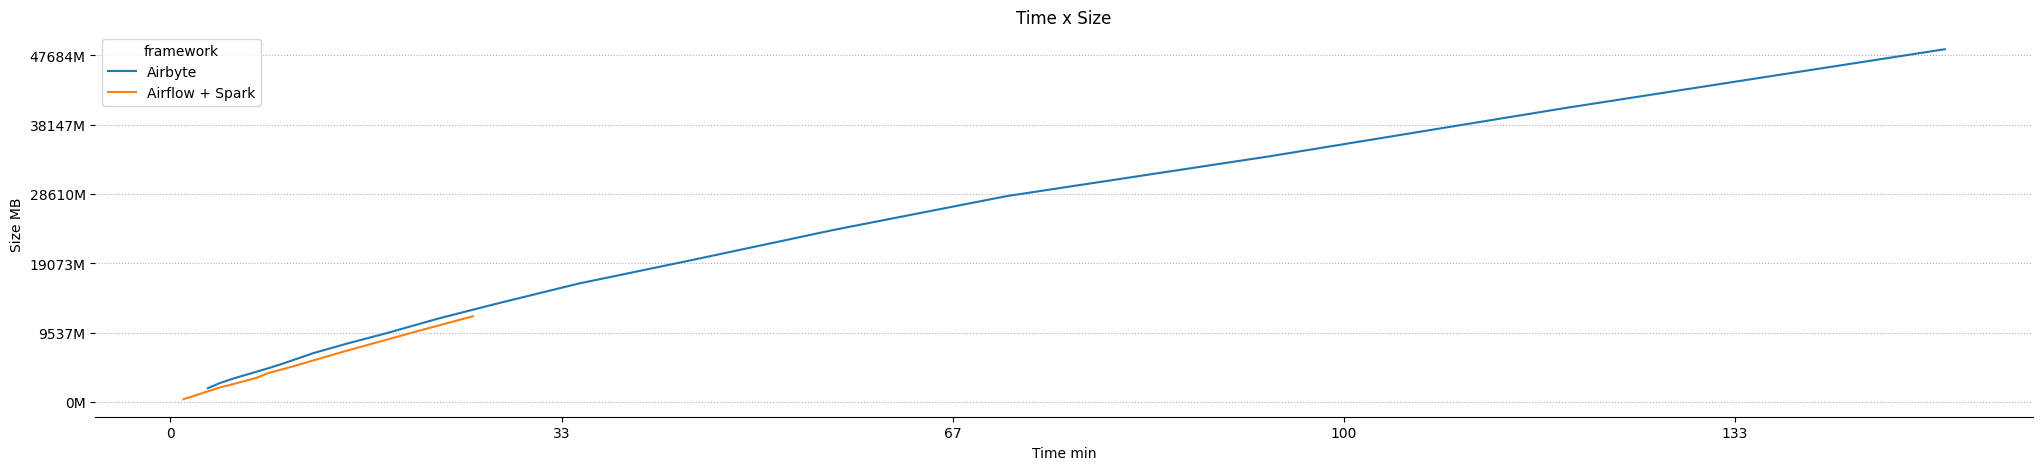

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
# sns.barplot(x="sf", y="time_delta", color="green", data=python_df, ax=ax[2])
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=source_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Number of Rows at Source")
    elif idx == 1:
        # Set y-axis frequency to rise by 2000 until 14000
        # ax[idx].yaxis.set_major_locator(range(0, 14000, 2000))
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title='Size at Source')
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
        ax[idx].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Source ( Python + psycopg2 )")
    ax[idx].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    sns.barplot(x="sf", y=col, hue="framework", data=target_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Quantity o lines at Target")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title="Total size of Target")
    ax[idx].grid(axis='y', linestyle=':')
# sns.despine(left=True)
# plt.show()

source_status_combined = source_status_combined.sort_values(by=["framework", "sf"]).reset_index(drop=True)
sns.barplot(x="sf", y="TimeDelta", hue="framework", data=source_status_combined, ax=ax[2])
# Set y-axis scale to millions with separators
ax[2].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax[2].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Target")
ax[2].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

df_throughput = df_throughput.sort_values(by=["framework", "sf"]).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x="sf", y="Throughput", hue="framework", data=df_throughput, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'M')
ax.set(ylabel="rows/sec", xlabel="Scale Factor", title="Throughput")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

temp_df = target_grouped.merge(source_status_combined, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")

fig, ax = plt.subplots(figsize=(25, 5))
sns.lineplot(x="TimeDelta", y="total_size_bytes", hue="framework", data=temp_df, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024) + 'M')
ax.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax.set(ylabel="Size MB", xlabel="Time min", title="Time x Size")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

# Post Analisys

In [41]:
url = 'http://192.168.1.126:9090'
# Connect
prom = PrometheusConnect(url=url, disable_ssl=True)

my_metrics = [
    "node_cpu_seconds_total", # Seconds the CPUs spent in each mode
    "node_filesystem_avail_bytes", # Filesystem space available to non-root users in bytes.
    "node_filesystem_size_bytes", # Filesystem size in bytes.
    "node_memory_Buffers_bytes", # Memory information field Buffers_bytes.
    "node_memory_Cached_bytes", # Memory information field Cached_bytes.
    'node_memory_SReclaimable_bytes',
    'node_memory_MemFree_bytes',
    'node_memory_MemTotal_bytes',
    "pg_stat_database_tup_deleted",
    "pg_stat_database_tup_fetched",
    "pg_stat_database_tup_inserted",
    "pg_stat_database_tup_returned",
    "pg_stat_database_tup_updated",
    "pg_database_size_bytes"
]

In [112]:
status_fixed_time = status.copy()
status_fixed_time = status_fixed_time.merge(target_grouped, left_on=["framework", "benchmark_id"],
                                            right_on=["framework", "benchmark_id"], how="inner")

cols = ['benchmark_id', 'startTime', 'TimeDelta', "operation", "framework", "sf", "rows_count", "total_size_bytes"]
status_fixed_time = pd.concat([status_fixed_time, status_airbyte.merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")[cols]])

mask = status_fixed_time.endTime.isnull()
status_fixed_time.loc[mask, "endTime"] = status_fixed_time.loc[mask, "startTime"] + status_fixed_time.loc[mask, "TimeDelta"].apply(lambda x: timedelta(seconds=x))
status_fixed_time.reset_index(drop=True, inplace=True)
status_fixed_time.startTime = status_fixed_time.startTime# - timedelta(hours=3)
status_fixed_time.endTime = status_fixed_time.endTime# - timedelta(hours=3)

status_fixed_time.tail(3)

,benchmark_id,startTime,endTime,TimeDelta,operation,framework,sf,rows_count,total_size_bytes
34,MjAyMzExMDcyMDEwNTY=,2023-11-07 20:15:14,2023-11-07 21:48:53,5619.0,sync_airbyte,Airbyte,50,160908902,35449126912
35,MjAyMzExMDcyMTUwMDg=,2023-11-07 21:55:49,2023-11-07 23:54:50,7141.0,sync_airbyte,Airbyte,60,192679040,42459979776
36,MjAyMzExMDcyMzU2MTc=,2023-11-08 00:02:28,2023-11-08 02:33:41,9073.0,sync_airbyte,Airbyte,72,231094320,50900983808


In [113]:
status_fixed_time

,benchmark_id,startTime,endTime,TimeDelta,operation,framework,sf,rows_count,total_size_bytes
0,MjAyMzExMDgxMjM3NDQ=,2023-11-08 12:38:07.590649,2023-11-08 12:39:14.198780,66.61,sync_airflow,Airflow + Spark,3,4525390,409387008
1,MjAyMzExMDgxMjM5MTU=,2023-11-08 12:39:41.551226,2023-11-08 12:41:04.374189,82.82,sync_airflow,Airflow + Spark,4,6160471,558178304
2,MjAyMzExMDgxMjQxMDk=,2023-11-08 12:41:40.638150,2023-11-08 12:43:19.428467,98.79,sync_airflow,Airflow + Spark,5,7779939,701153280
3,MjAyMzExMDgxMjQzMjU=,2023-11-08 12:43:58.791812,2023-11-08 12:45:54.192927,115.40,sync_airflow,Airflow + Spark,6,9413149,849788928
4,MjAyMzExMDgxMjQ1NTk=,2023-11-08 12:46:36.488988,2023-11-08 12:48:46.990496,130.50,sync_airflow,Airflow + Spark,7,11043145,993607680
5,MjAyMzExMDgxMjQ4NTE=,2023-11-08 12:49:30.244871,2023-11-08 12:51:57.871998,147.63,sync_airflow,Airflow + Spark,8,12676479,1142317056
6,MjAyMzExMDgxMjUyMDE=,2023-11-08 12:52:48.201165,2023-11-08 12:55:46.023150,177.82,sync_airflow,Airflow + Spark,10,15930433,1434042368
7,MjAyMzExMDgxMjU1NTA=,2023-11-08 12:56:44.703458,2023-11-08 13:00:17.043835,212.34,sync_airflow,Airflow + Spark,12,19182651,1725636608
8,MjAyMzExMDgxMzAwMjQ=,2023-11-08 13:01:22.754142,2023-11-08 13:05:23.592717,240.84,sync_airflow,Airflow + Spark,14,22446587,2018172928
9,MjAyMzExMDgxMzA1Mjg=,2023-11-08 13:06:33.847138,2023-11-08 13:11:37.024631,303.18,sync_airflow,Airflow + Spark,17,27337417,2458722304


In [130]:
def return_metrics(query, start_time, end_time):
    metric = prom.custom_query_range(
                query=query,  # this is the metric name and label config
                start_time=start_time,
                end_time=end_time,
                step="1m"
                )
    
    return metric
    
    
df_metrics = pd.DataFrame(columns=["benchmark_id", "framework", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size']) 
mask = status_fixed_time.framework == "Airbyte"
for row in status_fixed_time[~mask].itertuples():
    test_id = row.benchmark_id
    test_sf = row.sf
    framework = row.framework
    # CPU Consume

    t_delta = timedelta(hours=3)# if framework == "Airbyte" else timedelta(hours=0)
    start_time = row.startTime# + t_delta
    end_time = row.endTime# + t_delta
    # print(start_time, end_time, sep=" - ")
    #start_time = datetime.strptime('2023-11-08 10:20:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.startTime
    #end_time = datetime.strptime('2023-11-08 11:00:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.endTime

    query_cpu = 'sum by(instance)(irate(node_cpu_seconds_total{mode=~"user|system", instance!~"PROXMOX|STORAGE|AIRBYTE"}[1m])) / on(instance) group_left sum by(instance)(irate(node_cpu_seconds_total{instance!~"PROXMOX|STORAGE|AIRBYTE"}[1m]))'
    query_memory = 'node_memory_MemTotal_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE"} - node_memory_MemFree_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE"}' 
    query_buffer = 'node_memory_Cached_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE"} + node_memory_Buffers_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE"} + node_memory_SReclaimable_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE"}'
    query_fs_size = 'node_filesystem_size_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE", mountpoint="/"} - node_filesystem_avail_bytes{instance!~"PROXMOX|STORAGE|AIRBYTE", mountpoint="/"}'
    

    cpu_metric = return_metrics(query=query_cpu, start_time=start_time + t_delta, end_time=end_time + t_delta)
    ram_used_metric = return_metrics(query=query_memory, start_time=start_time + t_delta, end_time=end_time + t_delta)
    ram_buffer_metric = return_metrics(query=query_buffer, start_time=start_time + t_delta, end_time=end_time + t_delta)
    fs_size = return_metrics(query=query_fs_size, start_time=start_time + t_delta, end_time=end_time + t_delta)
    
    for cpu_item, memory_used_item, memory_buffer_item, fs_item in zip(cpu_metric, ram_used_metric, ram_buffer_metric, fs_size):
        cpu_instance = cpu_item['metric']['instance']
        cpu_usage = np.array(cpu_item['values'])[:,1]
    
        # memory_used_instance = memory_used_item['metric']['instance']
        memory_used_usage = np.array(memory_used_item['values'])[:,1]
        
        # memory_buffer_instance = memory_buffer_item['metric']['instance']
        memory_buffer_usage = np.array(memory_buffer_item['values'])[:,1]
        
        # fs_instance = fs_item['metric']['instance']
        fs_usage = np.array(fs_item['values'])[:,1]
        
        aux_metrics = pd.Series([framework, test_id, test_sf, cpu_instance, cpu_usage, memory_used_usage, memory_buffer_usage, fs_usage],
                                index=['framework', "benchmark_id", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size'], name=0).to_frame().T    
        df_metrics = pd.concat([df_metrics, aux_metrics], ignore_index=True)

# print(start_time, end_time, sep="\n")

In [131]:
df_cpu = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'cpu_usage']].explode("cpu_usage").reset_index(drop=True)
df_memory = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_usage']].explode("memory_usage").reset_index(drop=True)
df_buffer = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_buffer']].explode("memory_buffer").reset_index(drop=True)
df_fs = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'filesystem_size']].explode("filesystem_size").reset_index(drop=True)

In [132]:
melted_list = []
for idx, ii in enumerate([df_cpu, df_memory, df_buffer, df_fs]):
    cols = ii.columns
    ii.sf = ii.sf.astype(int)
    ii[cols[-1]] = ii[cols[-1]].astype(float)   
    if idx == 0:
        ii[cols[-1]] = ii[cols[-1]] * 100
    elif idx == 3:
        ii[cols[-1]] = ii[cols[-1]] / 1000 / 1000 / 1000
    else:
        ii[cols[-1]] = ii[cols[-1]] / 1024 / 1024 / 1024
    
    temp = ii.melt(id_vars=["benchmark_id", "framework", "sf", 'instance'])
    temp = temp[['framework', 'sf', 'instance', 'value']]

    
    melted_list.append(temp)

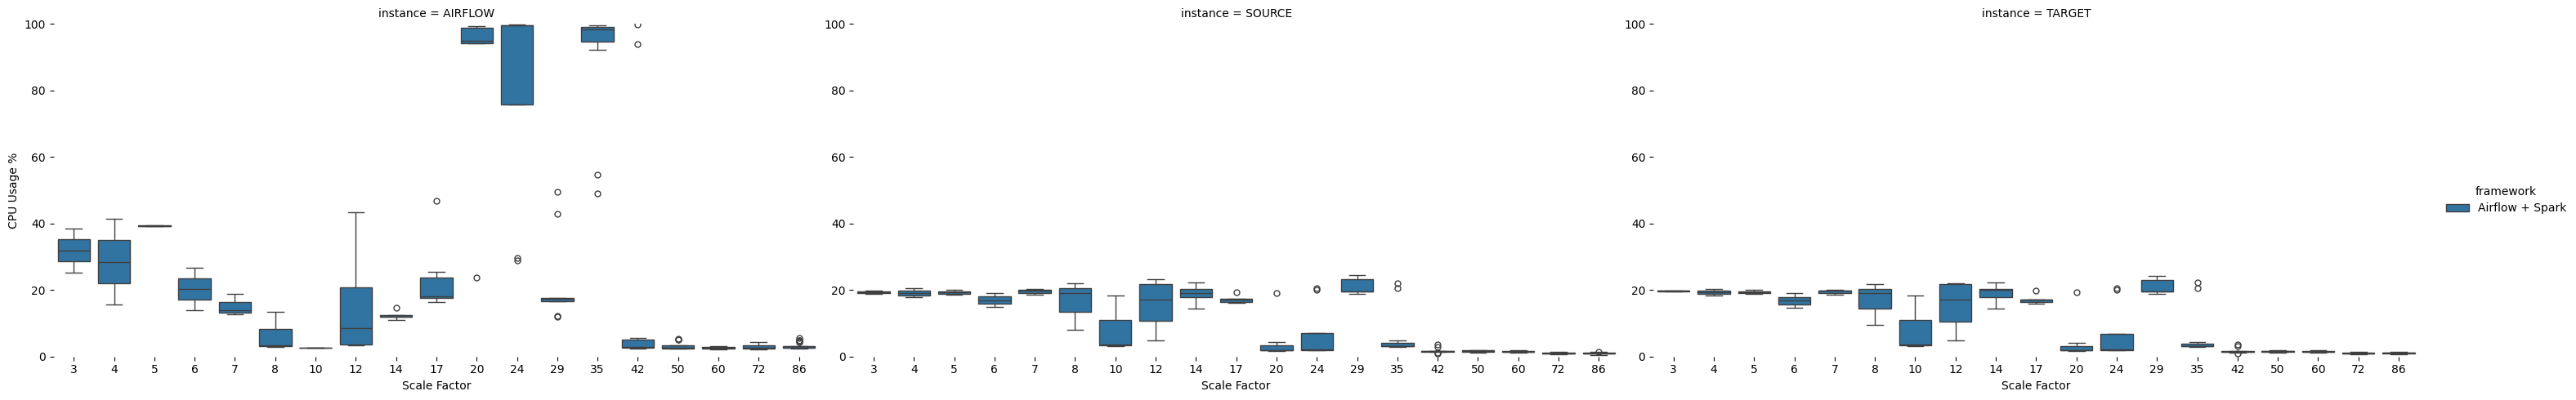

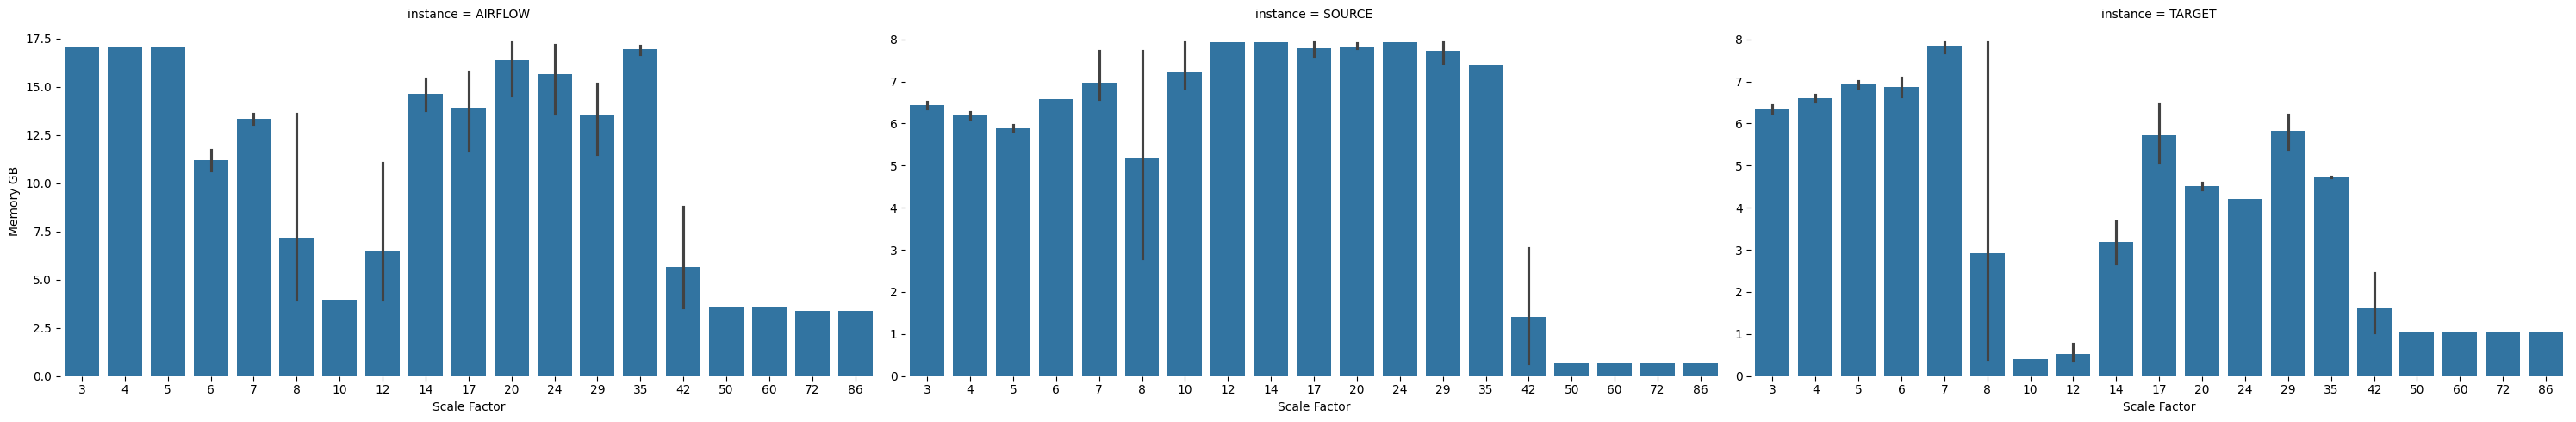

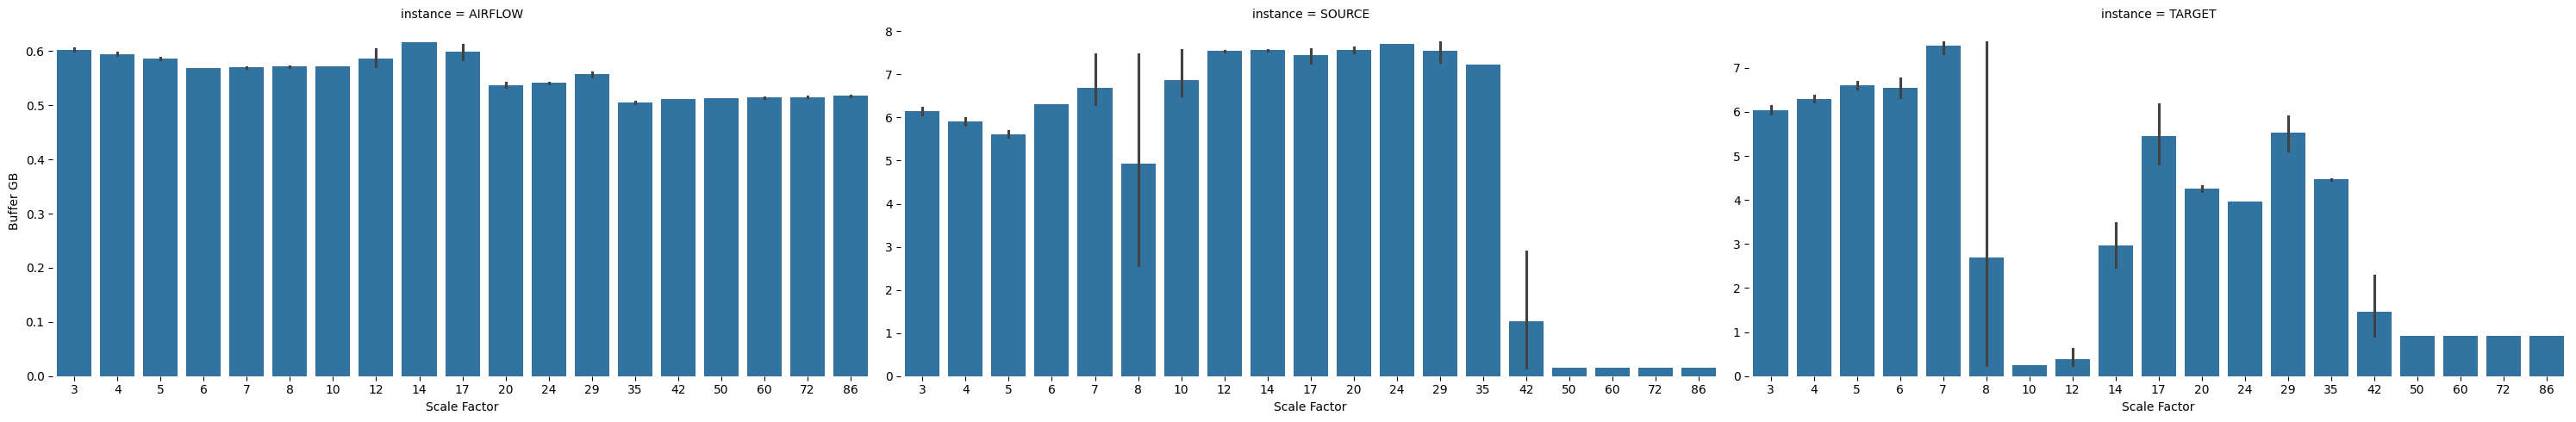

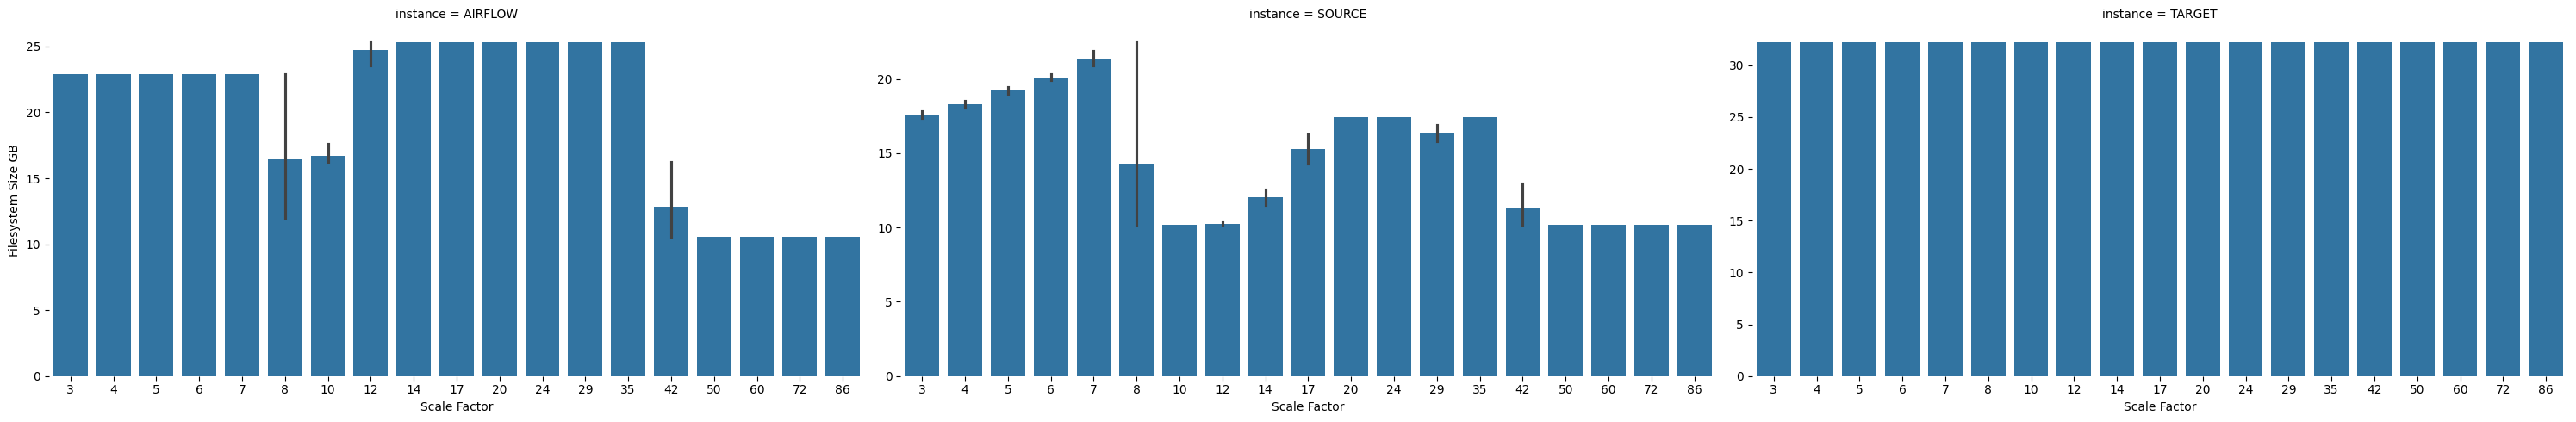

In [133]:
for idx, ii in enumerate(melted_list):
    if idx == 0:
        g = sns.catplot(ii, x='sf', y='value', hue='framework', kind='box', col='instance', col_wrap=3, height=5, aspect=2, sharex=True, sharey=False)
    else:
        g = sns.FacetGrid(ii, col='instance', hue='framework', col_wrap=3, height=5, aspect=2, sharex=True, sharey=False)
        g.map(sns.barplot, 'sf', 'value', order=ii.sf.unique())
    
    if idx == 0:
        g.set(ylim=(0, 100))
        g.set_axis_labels("Scale Factor", "CPU Usage %")        
    elif idx == 3:
        g.set_axis_labels("Scale Factor", "Filesystem Size GB")
    elif idx == 1:
        g.set_axis_labels("Scale Factor", "Memory GB")    
    else:
        g.set_axis_labels("Scale Factor", "Buffer GB")
    
    g.despine(left=True, bottom=True)
    plt.show()